In [1]:
# Getting started

In [2]:
push!(LOAD_PATH, "../../../ExoJulia/")

3-element Array{ByteString,1}:
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/local/share/julia/site/v0.4"
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/share/julia/site/v0.4"      
 "../../../ExoJulia/"                                                                

In [3]:
Pkg.add("LsqFit")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of LsqFit
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [4]:
using ExoJulia
using PyPlot
using LsqFit

### Define a handful of useful functions

In [5]:
function v_semi_amp!(P::Float64, ecc::Float64, inc::Float64, Mp::Float64, Ms::Float64)
    (2.0pi / (P * (1.0 - e*e)^(3./2.)) * (Mp*sin(inc))^3 / (Mp + Ms)^2)^(1./3.)
end

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


v_semi_amp! (generic function with 1 method)

In [6]:
function v_rad!(K::Float64, w::Float64, f::Float64, ecc::Float64, gamma::Float64)
    K * (cos(w+f) + e*sin(w)) + gamma
end

v_rad! (generic function with 1 method)

In [7]:
function v_rad_lin!(h::Float64, f::Float64, c::Float64, v0::Float64)
    h*cos(f) + c*sin(f) + v0
end

v_rad_lin! (generic function with 1 method)

In [8]:
function mean_anaomoly!(P::Float64, t::Float64, t0::Float64)
    (2.0pi / P) * (t-t0)
end

mean_anaomoly! (generic function with 1 method)

In [9]:
function f_from_E!(E::Float64, ecc::Float64)
    2.0 * atan2(sqrt(1.0 - ecc) * cos(E/2.0), sqrt(1.0 + e) * sin(E/2.0))
end

f_from_E! (generic function with 1 method)

In [10]:
function r_from_f!(a::Float64, ecc::Float64, f::Float64)
    a * (1.0 - ecc*ecc) / (1.0 - ecc*cos(f))
end

r_from_f! (generic function with 1 method)

In [11]:
function f_from_M!(ecc::Float64, M::Float64)
    f_from_E!(ExoJulia.Orbit.kepler_solve!(M, ecc), ecc)
end

f_from_M! (generic function with 1 method)

### Read-in Mystery RV data

In [12]:
numbers = readdlm("mystery_planet.txt");

In [13]:
time = numbers[:,1];
rv = numbers[:,2];
err = numbers[:,end];

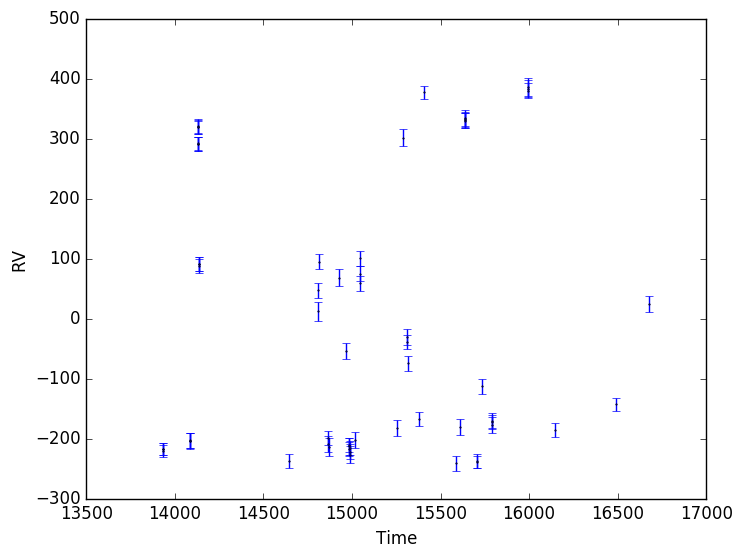

PyObject <matplotlib.text.Text object at 0x31a730890>

In [14]:
errorbar(time, rv, yerr=err*10.0, fmt="o", ms=1)
xlabel("Time")
ylabel("RV")

## Period Fitting

In [15]:
function argmin(x)
    MIN = 1.0e-10
    for i=1:length(x)
        if (x[i] - minimum(x)) < MIN
            return i
        end 
    end
end 

argmin (generic function with 1 method)

### Agol Method

In [16]:
periods = linspace(1.0, 365.0, 10000)

linspace(1.0,365.0,10000)

In [17]:
data = copy(numbers);

In [18]:
dv = zeros(length(periods));

In [19]:
for i=1:length(periods)
    numbers = copy(data)
    numbers[:,1] = mod(numbers[:,1] - numbers[1,1], periods[i])
    numbers = sortrows(numbers, by=x->(x[1]))
    for j=2:length(rv)
        dv[i] += (numbers[j,2] - numbers[j-1,2])^2 
    end
end

//anaconda/lib/python2.7/site-packages/matplotlib/axis.py:1015: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
//anaconda/lib/python2.7/site-packages/matplotlib/axis.py:1025: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


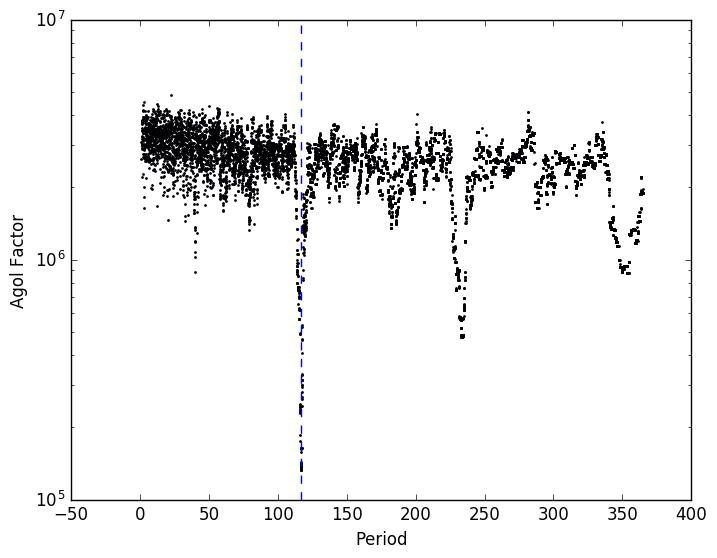

PyObject <matplotlib.text.Text object at 0x319765910>

In [20]:
scatter(periods, dv, s=1)
semilogy()
axvline(periods[argmin(dv)], ls="--")
xlabel("Period")
ylabel("Agol Factor")

In [21]:
periods[argmin(dv)]

116.65436543654366

In [86]:
function agol_periodogram(data::Array{Float64,2}, periods::Array{Float64,1})
    
    dv = zeros(length(periods));
    
    for i=1:length(periods)
        numbers = copy(data);
        numbers[:,1] = mod(numbers[:,1] - numbers[1,1], periods[i])
        numbers = sortrows(numbers, by=x->(x[1]))
        for j=2:length(rv)
            dv[i] += (numbers[j,2] - numbers[j-1,2])^2 
        end
    end
    
    periods[argmin(dv)]
end

agol_periodogram (generic function with 2 methods)

In [66]:
numbers = readdlm("mystery_planet.txt");

In [67]:
periods = linspace(0.1, 365.0, 5000)

linspace(0.1,365.0,5000)

In [68]:
p = collect(periods);

In [87]:
@time agol_periodogram(numbers, p)

116.67237447489498

0.829341 seconds (10.21 M allocations: 206.881 MB, 3.72% gc time)


In [63]:
length(numbers[:,1])

59

In [77]:
length(numbers[:,1])

59